**About** : This notebook is used to train models.

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

c:\Users\tviel\work\kaggle_islr\src


## Initialization

### Imports

In [3]:
import os
import torch

print(torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.cuda.get_device_name(0)
print(device)

1.12.1+cu116
NVIDIA RTX A3000 12GB Laptop GPU


In [4]:
import os
import sys
import glob
import json
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import *

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [5]:
# from training.main import k_fold

# from utils.logger import (
#     prepare_log_folder,
#     save_config,
#     create_logger,
#     init_neptune
# )
# from utils.metrics import pfbeta

from params import *
from utils.plots import *
# from data.dataset import *
# from data.preparation import *
# from data.transforms import get_transfos

# from model_zoo.models import define_model

### Folds

In [6]:
# from sklearn.model_selection import StratifiedGroupKFold
# K = 4

# df = pd.read_csv(DATA_PATH + "train.csv")

# sgkf = StratifiedGroupKFold(n_splits=K, shuffle=True, random_state=42)
# splits = sgkf.split(df, y=df['cancer'], groups=df['patient_id'])

# df['fold'] = -1
# for i, (_, val_idx) in enumerate(splits):
#     df.loc[val_idx, "fold"] = i
    
# df_folds = df[["patient_id", "image_id", "fold"]]
# df_folds.to_csv(f"/workspace/folds_{K}.csv", index=False)

## Data

In [ ]:
def prepare_data(data_path="../input/"):
    df = pd.read_csv(DATA_PATH + "train.csv")

In [8]:
df["participant_id"].value_counts().max()

4968

In [9]:
classes = json.load(open(DATA_PATH + "sign_to_prediction_index_map.json", "r"))

In [10]:
df["target"] = df["sign"].map(classes)

df['path'] = DATA_PATH + df['path']

In [11]:
sign = pd.read_parquet(df['path'][0])
sign["y"] *= -1

In [12]:
sign

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,-0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,-0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,-0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,-0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,-0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,-0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,-0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,-0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,-0.643799,-0.123488


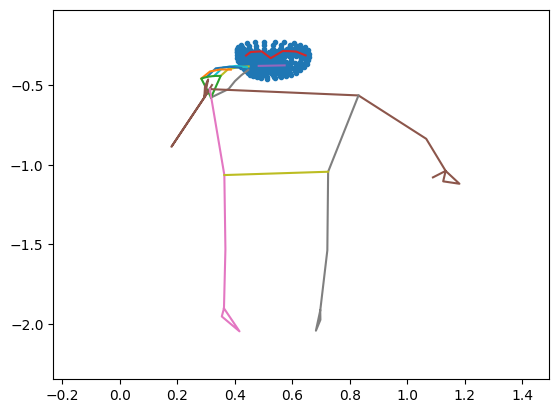

In [13]:
fig, ax = plt.subplots()
l, = ax.plot([], [])

plot_frame(sign['frame'].unique()[0], sign, ax)

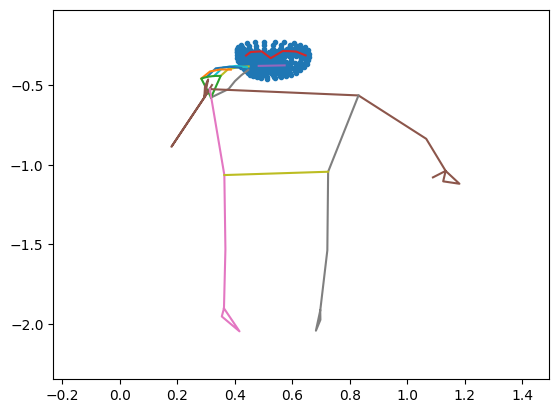

In [14]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=lambda x: plot_frame(x, sign, ax), frames=sign.frame.unique())

In [26]:
def create_animation(imgs, titles=[]):
    fig = plt.figure(figsize=(15, 10))

    im = plt.imshow(imgs[0], cmap="gray")
    plt.axis(False)

    if len(titles):
        fig.suptitle(f'{titles[0]}')
    plt.close()

    def animate_func(i):
        im.set_array(imgs[i])
        if len(titles):
            fig.suptitle(f'{titles[i]}')
        return [im]

    return FuncAnimation(fig, animate_func, frames=len(imgs), interval=1000 // 24)

In [27]:
# create_animation([np.ones((50, 50)) for k in range(5)])

In [ ]:
# img_folder = "cbis_yolox_1536_1024/"
# df_extra = prepare_cbis_data(DATA_PATH, img_folder)

In [ ]:
df = prepare_data(DATA_PATH, "crops_512_512/")

In [ ]:
df.head()

In [ ]:
transforms = get_transfos(augment=False, resize=None, strength=3)

dataset = BreastCropDataset(df, transforms=transforms)

In [ ]:
# df.drop_duplicates(subset=['patient_id', 'laterality'], keep="first")[['site_id', 'cancer']].groupby("site_id").mean()

In [ ]:
# for i in tqdm(range(len(dataset))):

plt.figure(figsize=(15, 15))

for i in range(3):
    plt.subplot(3, 3, i + 1)

    idx = 0
    imgs, y, y_aux = dataset[idx]
    
#     if not y:
#         continue

    for j in range(3):
        plt.subplot(3, 3, i + 1 + j)
        plt.imshow(imgs[j].mean(0), cmap="gray")
        plt.axis(False)
    
        plt.title(f"{df['patient_id'][idx]} {df['image_id'][idx]}  - target = {int(y)} - crop {j}")
    break

plt.show()

## Model

In [ ]:
model = define_model('eca_nfnet_l1', num_classes=1, num_classes_aux=3, n_channels=3, reduce_stride=False, drop_path_rate=0., use_gem=True, crops=True)

In [ ]:
x = torch.cat([imgs.unsqueeze(0)] * 2)

pred, pred_aux = model(x)

In [ ]:
loss = model.loss(pred, torch.ones(2), torch.nn.CrossEntropyLoss(reduction="mean"), 0.1)

## Training

In [ ]:
MODELS = [
    # ResNets
    "resnet18",
    "resnext50_32x4d",
    "seresnext50_32x4d",

    # EfficientNets
    "tf_efficientnetv2_s",
    "tf_efficientnetv2_m",
    "tf_efficientnetv2_b0",
    "tf_efficientnetv2_b1",
]

In [ ]:
# import torch_performance_linter

In [ ]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda"
    save_weights = True

    # Images
    img_folder = "crop_1024_w/"
    resize = None
    aug_strength = 1

    # k-fold
    k = 4
    folds_file = f"../input/folds_{k}.csv"
    selected_folds = [0, 1, 2, 3]

    # Model
    name = "tf_efficientnet_b0"
    pretrained_weights = None # PRETRAINED_WEIGHTS[name]  # None
    num_classes = 1
    num_classes_aux = 3
    n_channels = 3
    reduce_stride = False

    # Training    
    loss_config = {
        "name": "bce",
        "smoothing": 0.,
        "activation": "sigmoid",
        "aux_loss_weight": 0.1,
        "pos_weight": None,
        "activation_aux": "softmax",
    }

    data_config = {
        "batch_size": 16,
        "val_bs": 16,
        "mix": "mixup",
        "mix_proba": 0.,
        "mix_alpha": 4.,
        "additive_mix": False,
        "use_len_sampler": False,
        "use_balanced_sampler": False,
        "use_weighted_sampler": False,
        "sampler_weights": [1, 1, 1, 1],  # pos, birads 0, 1, 2
        "use_custom_collate": False,
    }

    optimizer_config = {
        "name": "Ranger",
        "lr": 5e-4,
        "warmup_prop": 0.,
        "betas": (0.9, 0.999),
        "max_grad_norm": 10.,
    }

    epochs = 5

    use_fp16 = True

    verbose = 1
    verbose_eval = 500

In [ ]:
DEBUG = True
log_folder = None
run = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")
#     run = init_neptune(Config, log_folder)

df = prepare_data(DATA_PATH, DATA_PATH + Config.img_folder)

# df['cancer'] = (df['BIRADS'] <= 0).astype(int)
# df = df.dropna(axis=0).reset_index(drop=True)
# df = df.head(10000) if DEBUG else df

preds = k_fold(Config, df, log_folder=log_folder, run=run)

Done ! 